In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm as tqdm 
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix
import scipy.io as scio
from matplotlib import ticker

In [2]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 64,
                layers = 5,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module = []
        module.append(nn.Linear(2,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,2))
        
        self.u = nn.Sequential(*module)

    def forward(self, x):
        u_out = self.u(x)
        return  u_out

In [3]:
# Model parameters

β = 0.9
γ = 0.15
σ = 1.0
σ_A = 0.1
ρ_A = 0.8
α = 0.5

In [4]:
# Standard deviations for ergodic distributions of exogenous state variables

σ_e_A = σ_A/(1-ρ_A**2)**0.5

# bounds for endogenous state variable
Kmin = 0.1
Kmax = 8.0

# Weights of loss functions
vh = 1.0

In [5]:
def dr(A,K):

    # we normalize exogenous state variables by their 2 standard deviations 
    # so that they are typically between -1 and 1 
    A = A/σ_e_A/2
    
    # we normalze capital stock to be between -1 and 1
    K = (K-Kmin)/(Kmax-Kmin)*2.0-1.0

    # we prepare input to the perceptron
    s = torch.cat((A,K),1) # equivalent to np.column_stack

    x = c_hat(s) # n x 1 matrix 
    
    # consumption share is always in [0,1]
    ζ = torch.sigmoid( x[:,0] ).unsqueeze(1)
    
    # value function V(A,K)
    h = x[:,1].unsqueeze(1)
    
    return (ζ, h)

## The expected squared sum of residuals (Bellman Equation)

We construct the objective function for minimization as the squared sum of residuals in the model's equation on a given 2-dimensional domain $s=(A,K)$. Applying the all-in-one expectation operator:

$$
\begin{equation*}
\Xi (\theta )=E_{s}\left[1-\frac{\beta E_{\epsilon^{\prime}}\frac{\partial}{\partial k^{\prime}}V\left(
A^{\prime},k^{\prime}\right)}{u^{\prime }(c)}  \right] ^{2}+v_h E_{s}\left[V(s)-u(c)-\beta E_{\epsilon^{\prime}}V(s^{\prime}) \right] ^{2} \\
= E_{s,\epsilon_{1}^{\prime},\epsilon_{2}^{\prime}}\left[1-\frac{\beta \frac{\partial}{\partial k^{\prime}}V\left(A^{\prime},k^{\prime}\right)}{u^{\prime }(c)} |_{\epsilon_{1}^{\prime}} \right] \left[1-\frac{\beta \frac{\partial}{\partial k^{\prime}}V\left(A^{\prime},k^{\prime}\right)}{u^{\prime }(c)} |_{\epsilon_{2}^{\prime}} \right] + v_h E_{s,\epsilon_{1}^{\prime},\epsilon_{2}^{\prime}}\left[V(s)-u(c)-\beta V(s^{\prime}) |_{\epsilon_{1}^{\prime}} \right]\left[V(s)-u(c)-\beta V(s^{\prime}) |_{\epsilon_{2}^{\prime}} \right],
\end{equation*}
$$

In [6]:
def Residuals(e_A, A, K):

    # all inputs are expected to have the same size n
    n = A.size(0)

    # arguments correspond to the values of the states today
    ζ, h = dr(A,K)

    # transitions of the exogenous processes
    Anext = A*ρ_A + e_A
    
    # transition of endogenous states (next denotes variables at t+1)
    Knext = Variable((torch.exp(A)*K.pow(α) + (1-γ)*K)*(1-ζ),requires_grad=True)
    C = (torch.exp(A)*K.pow(α) + (1-γ)*K)*ζ
    ζnext, hnext = dr(Anext,Knext)
    
    hnext.backward(torch.ones(n,1),retain_graph=True)
    Vk_prime = Knext.grad
    
    R1 = 1.0-β*(1/C).pow(-σ)*Vk_prime
    R2 = h-torch.log(C)-β*hnext

    return (R1,R2)

In [7]:
max_epochs = 10000
torch.manual_seed(123)

In [8]:
c_hat = NN()
learning_rate = 3e-3

optimizer = torch.optim.Adam(c_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)

In [9]:
Kvec = torch.linspace(Kmin, Kmax, 100).unsqueeze(1)
ζvec, hvec = dr(Kvec*0, Kvec)
Knvec = (Kvec.pow(α) + (1-γ)*Kvec)*(1-ζvec)

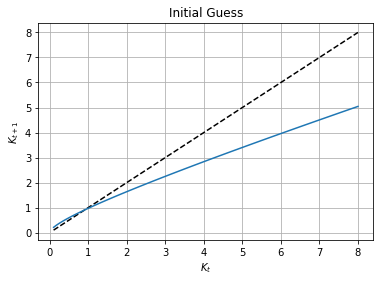

In [10]:
plt.plot(Kvec, Kvec, linestyle='--', color='black')
plt.plot(Kvec, Knvec.detach())
plt.xlabel("$K_t$")
plt.ylabel("$K_{t+1}$")
plt.title("Initial Guess")
plt.grid()

In [11]:
def Ξ(n): # objective function for DL training

    # randomly drawing current states
    A = torch.randn(n,1)*σ_e_A
    K = Variable(torch.rand(n,1)*(Kmax-Kmin)+Kmin,requires_grad=True)
 
    # randomly drawing 1st realization for shocks
    e1_A = torch.randn(n,1)*σ_A

    # randomly drawing 2nd realization for shocks
    e2_A = torch.randn(n,1)*σ_A
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(e1_A, A, K)
    R1_e2, R2_e2 = Residuals(e2_A, A, K)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + vh*R2_e1*R2_e2 
    
    # compute average across n random draws
    return torch.mean(R_squared)

# Model training

In [12]:
n = 128
v = Ξ(n)
vals = []

In [13]:
for epoch in tqdm(range(max_epochs)):
    loss = Ξ(n)
    vals.append(loss.detach())
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    scheduler.step()  

100%|██████████| 10000/10000 [01:04<00:00, 153.87it/s]


/var/folders/xn/khvmmtmj587826zjzpgz41fm0000gn/T/ipykernel_18062/921704333.py:2: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(vals) )


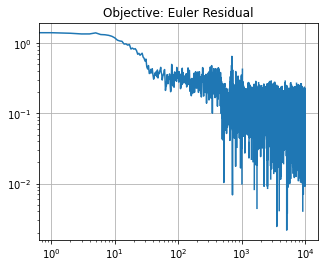

In [14]:
plt.figure().set_size_inches(5,4)
plt.plot(np.sqrt(vals) )
plt.title("Objective: Euler Residual")
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [15]:
VFIdata = scio.loadmat('/Users/siyuchen/Documents/VFI_AR1')
K,Value,Kprime,Consp = VFIdata['K'], VFIdata['V'],VFIdata['Kprime'],VFIdata['Consp']
nl, nm, nh = 4, 8, 12

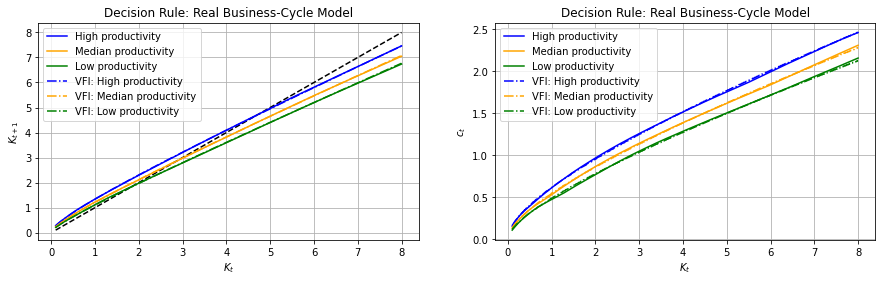

In [16]:
c_hat.eval()
Kvec = torch.linspace(Kmin, Kmax, 1000).unsqueeze(1)
Avec_h, Avec_m, Avec_l = torch.ones(1000,1)*(0.1),torch.ones(1000,1)*(-0.1),torch.ones(1000,1)*(-0.3)
cvec_h, hvec_h = dr(Avec_h, Kvec)
cvec_m, hvec_m = dr(Avec_m, Kvec)
cvec_l, hvec_l = dr(Avec_l, Kvec)
Knvec_h, Knvec_m, Knvec_l = (torch.exp(Avec_h)*Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec_h), (torch.exp(Avec_m)*Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec_m), (torch.exp(Avec_l)*Kvec.pow(α) + (1-γ)*Kvec)*(1-cvec_l)
Cvec_h, Cvec_m, Cvec_l = (torch.exp(Avec_h)*Kvec.pow(α) + (1-γ)*Kvec)*cvec_h, (torch.exp(Avec_m)*Kvec.pow(α) + (1-γ)*Kvec)*cvec_m, (torch.exp(Avec_l)*Kvec.pow(α) + (1-γ)*Kvec)*cvec_l

plt.figure().set_size_inches(15,4)
plt.subplot(1,2,1)
plt.plot(Kvec, Kvec, linestyle='--', color='black')
plt.plot(Kvec, Knvec_h.detach(),label= r"High productivity",color='blue')
plt.plot(Kvec, Knvec_m.detach(),label= r"Median productivity",color='orange')
plt.plot(Kvec, Knvec_l.detach(),label= r"Low productivity",color='green')
plt.plot(K, Kprime[:,nh],label= r"VFI: High productivity",color='blue',linestyle='-.')
plt.plot(K, Kprime[:,nm],label= r"VFI: Median productivity",color='orange',linestyle='-.')
plt.plot(K, Kprime[:,nl],label= r"VFI: Low productivity",color='green',linestyle='-.')
plt.xlabel("$K_t$")
plt.ylabel("$K_{t+1}$")
plt.title("Decision Rule: Real Business-Cycle Model")
plt.legend(loc='best')
plt.grid()
plt.subplot(1,2,2)
plt.plot(Kvec, Cvec_h.detach(),label= r"High productivity",color='blue')
plt.plot(Kvec, Cvec_m.detach(),label= r"Median productivity",color='orange')
plt.plot(Kvec, Cvec_l.detach(),label= r"Low productivity",color='green')
plt.plot(K, Consp[:,nh],label= r"VFI: High productivity",color='blue',linestyle='-.')
plt.plot(K, Consp[:,nm],label= r"VFI: Median productivity",color='orange',linestyle='-.')
plt.plot(K, Consp[:,nl],label= r"VFI: Low productivity",color='green',linestyle='-.')
plt.xlabel("$K_t$")
plt.ylabel("$c_{t}$")
plt.title("Decision Rule: Real Business-Cycle Model")
plt.legend(loc='best')
plt.grid()

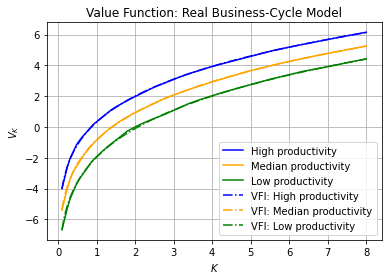

In [17]:
plt.plot(Kvec, hvec_h.detach(),label= r"High productivity",color='blue')
plt.plot(Kvec, hvec_m.detach(),label= r"Median productivity",color='orange')
plt.plot(Kvec, hvec_l.detach(),label= r"Low productivity",color='green')
plt.plot(Kvec, Value[:,nh],label= r"VFI: High productivity",color='blue',linestyle='-.')
plt.plot(Kvec, Value[:,nm],label= r"VFI: Median productivity",color='orange',linestyle='-.')
plt.plot(Kvec, Value[:,nl],label= r"VFI: Low productivity",color='green',linestyle='-.')
plt.xlabel("$K$")
plt.ylabel("$V_{K}$")
plt.title("Value Function: Real Business-Cycle Model")
plt.legend(loc='best')
plt.grid()

## Comparison of the methods: Euler Equation and Bellman Equation

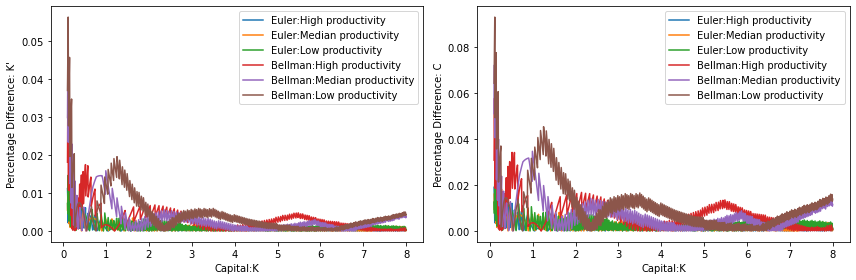

In [18]:
c_h,c_m,c_l,k_h,k_m,k_l = torch.load("./euler_0.pth")
Consp = torch.tensor(Consp)
Kprime = torch.tensor(Kprime)

Dc1_h,Dc1_m,Dc1_l = abs(c_h.squeeze(1)-Consp[:,nh])/Consp[:,nh],abs(c_m.squeeze(1)-Consp[:,nm])/Consp[:,nm],abs(c_l.squeeze(1)-Consp[:,nl])/Consp[:,nl]
Dk1_h,Dk1_m,Dk1_l = abs(k_h.squeeze(1)-Kprime[:,nh])/Kprime[:,nh],abs(k_m.squeeze(1)-Kprime[:,nm])/Kprime[:,nm],abs(k_l.squeeze(1)-Kprime[:,nl])/Kprime[:,nl]

Dc2_h,Dc2_m,Dc2_l = abs(Cvec_h.detach().squeeze(1)-Consp[:,nh])/Consp[:,nh],abs(Cvec_m.detach().squeeze(1)-Consp[:,nm])/Consp[:,nm],abs(Cvec_l.detach().squeeze(1)-Consp[:,nl])/Consp[:,nl]
Dk2_h,Dk2_m,Dk2_l = abs(Knvec_h.detach().squeeze(1)-Kprime[:,nh])/Kprime[:,nh],abs(Knvec_m.detach().squeeze(1)-Kprime[:,nm])/Kprime[:,nm],abs(Knvec_l.detach().squeeze(1)-Kprime[:,nl])/Kprime[:,nl]

plt.figure().set_size_inches(12,4)
plt.subplot(1,2,1)
plt.plot(Kvec,Dk1_h,label= r"Euler:High productivity")
plt.plot(Kvec,Dk1_m,label= r"Euler:Median productivity" )
plt.plot(Kvec,Dk1_l,label= r"Euler:Low productivity" )
plt.plot(Kvec,Dk2_h,label= r"Bellman:High productivity")
plt.plot(Kvec,Dk2_m,label= r"Bellman:Median productivity" )
plt.plot(Kvec,Dk2_l,label= r"Bellman:Low productivity" )
plt.ylabel(r"Percentage Difference: K'")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(Kvec,Dc1_h,label= r"Euler:High productivity")
plt.plot(Kvec,Dc1_m,label= r"Euler:Median productivity" )
plt.plot(Kvec,Dc1_l,label= r"Euler:Low productivity" )
plt.plot(Kvec,Dc2_h,label= r"Bellman:High productivity")
plt.plot(Kvec,Dc2_m,label= r"Bellman:Median productivity" )
plt.plot(Kvec,Dc2_l,label= r"Bellman:Low productivity" )
plt.ylabel(r"Percentage Difference: C")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Distance.pdf")
plt.show()



## Envelop Condition

In [19]:
n=20
A = torch.randn(n,1)*σ_e_A
K = Variable(torch.rand(n,1)*(Kmax-Kmin)+Kmin,requires_grad=True)
ζ, h = dr(A,K)
C = (torch.exp(A)*K.pow(α) + (1-γ)*K)*ζ
    
mc1 = β*(α*torch.exp(A)*K.pow(α-1)+1-γ)*(C).pow(-σ)

h.backward(torch.ones(n,1),retain_graph=True)
mc2 = K.grad

print(torch.cat((mc1,mc2),1))



tensor([[ 0.4207,  0.4841],
        [ 0.5963,  0.6469],
        [12.0501, 10.6030],
        [ 0.3993,  0.4871],
        [ 0.6734,  0.7645],
        [ 0.4681,  0.5319],
        [ 0.7492,  0.8552],
        [ 0.5043,  0.5758],
        [ 1.7645,  2.0774],
        [ 0.6188,  0.6462],
        [ 0.7064,  0.8037],
        [ 1.9688,  2.1376],
        [ 0.4045,  0.4860],
        [ 1.1712,  1.1833],
        [ 0.9050,  0.9849],
        [ 1.0022,  1.2455],
        [ 1.1150,  1.3871],
        [ 0.8082,  0.8789],
        [ 0.7285,  0.8233],
        [ 0.3839,  0.4399]], grad_fn=<CatBackward0>)
